In [3]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RationalQuadratic, RBF
from output import format_for_submission
import csv

In [4]:
random.seed(51)

def get_function_data(function_number):
    ary_in = np.load(f'../data/raw/initial_data/function_{function_number}/initial_inputs.npy')
    ary_out = np.load(f'../data/raw/initial_data/function_{function_number}/initial_outputs.npy')

    week1_out = [0.0, -0.03634716524130564, -0.13995571712281177, -11.512791229057324, 351.7115420928652, -0.5971511450896173, 0.2910786825809617, 8.618272750952901]
    week1_in = [np.array([0.00367, 0.9999 ]), 
                np.array([0.851999, 0.973204]), 
                np.array([0.747032, 0.28413 , 0.226329]), 
                np.array([0.169128, 0.756136, 0.275457, 0.528761]), 
                np.array([0.439601, 0.772709, 0.376277, 0.933269]), 
                np.array([0.232204, 0.132714, 0.53824 , 0.760706, 0.075595]), 
                np.array([0.476821, 0.248196, 0.242816, 0.576157, 0.162416, 0.290926]), 
                np.array([0.221603, 0.703755, 0.674607, 0.130295, 0.376739, 0.669444, 0.136655, 0.061316])]    
    
    week2_out = [-1.2075460499722905e-18, 0.17608630702211278, -0.17239781799687137, -31.982880235497266, 1236.8846557000643, -2.451406055102475, 0.00010805707939840242, 5.178959940699899]
    week2_in = [np.array([0.476035, 0.572563]), 
                np.array([0.641846, 0.498841]), 
                np.array([0., 0., 0.]), 
                np.array([0.953433, 0.895217, 0.812477, 0.618719]), 
                np.array([0.987523, 0.470227, 0.946409, 0.105412]), 
                np.array([3.40696e-01, 4.94179e-01, 2.10000e-05, 3.08050e-02, 9.39958e-01]), 
                np.array([0.88314 , 0.756642, 0.      , 0.      , 0.9     , 0.942719]), 
                np.array([0.993634, 0.968223, 0.979285, 0.397318, 0.965856, 0.955218, 0.006078, 0.024001])]

    ary_out=np.append(ary_out, week1_out[function_number-1])
    ary_out=np.append(ary_out, week2_out[function_number-1])
    ary_in=np.vstack((ary_in, week1_in[function_number-1]))
    ary_in=np.vstack((ary_in, week2_in[function_number-1]))
    
    return ary_in, ary_out

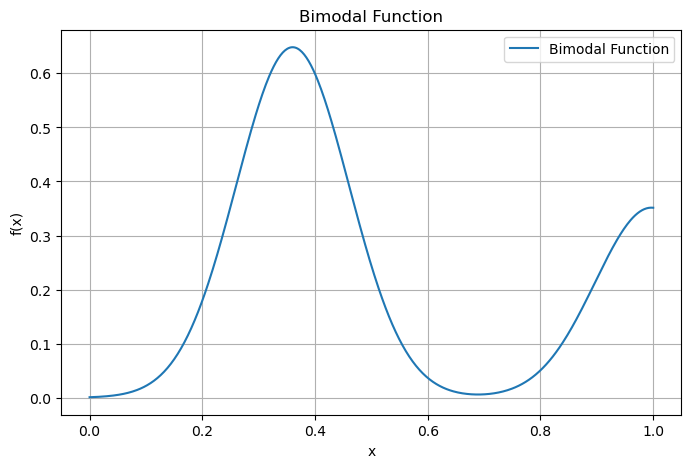

Max from grid search: 0.6483588866639842


In [8]:
#Test bimodal function
class one_d_test:
    # Parameters for the two Gaussian peaks
    #mu1 is x of first peak
    #mu2 is x of second peak TODO: experiment with 0.02-0.2
    #Sigmas are widths of peaks
    #alpha1 is weight of first peak (default 1)
    #alpha2 is weight of second peak (default 0.5)

    sigma1 = 0.1
    sigma2 = 0.1
    mu1 = 0.3
    mu2 = 0.7
    alpha1 = 1
    alpha2 = 0.5

    def __init__(self, sigma1=0.1, sigma2=0.1, mu1=0.3, mu2=0.7, alpha1=1, alpha2=0.5):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    def call_function(self, x): 
        # Calculate the two Gaussian components
        gaussian1 = np.exp(-((x - self.mu1) ** 2) / (2 * self.sigma1 ** 2))
        gaussian2 = np.exp(-((x - self.mu2) ** 2) / (2 * self.sigma2 ** 2))
        gaussian1 = self.alpha1 * gaussian1
        gaussian2 = self.alpha2 * gaussian2
        
        # Combine and normalize to keep the output between 0 and 1
        result = (gaussian1 + gaussian2) / (self.alpha1 + self.alpha2)
        return result

# Test the function with a range of values
x = np.linspace(0, 1, 500)
testmu1 = random.random()
testmu2 = random.random()
testalpha2 = random.uniform(0.3, 0.9)
oned = one_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
y = oned.call_function(x)

# Plot the function
plt.figure(figsize=(8, 5))
plt.plot(x, y, label="Bimodal Function")
plt.title("Bimodal Function")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.grid(True)
plt.legend()
plt.show()


print("Max from grid search:", np.max(y))

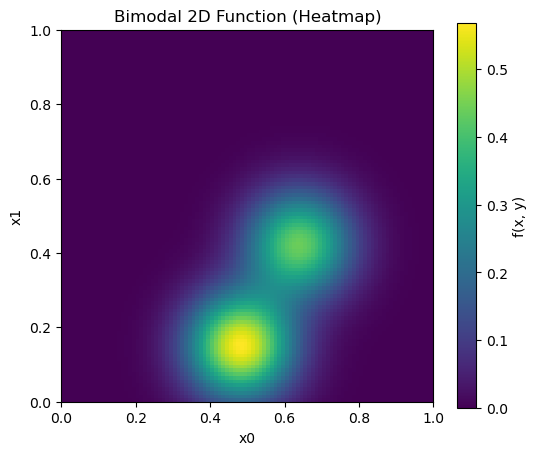

Max from grid search: 0.5671041065151622


In [22]:
class two_d_test:

    def __init__(self, sigma1=0.1, sigma2=0.1, mu1=[0.3,0.3], mu2=[0.7,0.7], alpha1=1, alpha2=0.5):
        self.sigma1 = sigma1
        self.sigma2 = sigma2
        self.mu1 = mu1
        self.mu2 = mu2
        self.alpha1 = alpha1
        self.alpha2 = alpha2

    sigma1 = 0.1
    sigma2 = 0.1
    mu1 = [0.3,0.3]
    mu2 = [0.7,0.7]
    alpha1 = 1
    alpha2 = 0.5

    def call_function(self, X):
        """
        Bimodal function f(x0, x1) in [0, 1]^2 -> [0, 1].
        X is an array of shape (N, 2).
        Returns a 1D array of length N, each element in [0, 1].
        """

        X = np.asarray(X)
        X = np.atleast_2d(X)  # Ensure X is 2D
        x0 = X[:, 0]  # shape (N,)
        x1 = X[:, 1]  # shape (N,)

        # 2D Gaussian around (mu1[0], mu1[1])
        g1 = np.exp(-(((x0 - self.mu1[0]) ** 2) / (2 * self.sigma1 ** 2)
                      + ((x1 - self.mu1[1]) ** 2) / (2 * self.sigma1 ** 2)))

        # 2D Gaussian around (mu2[0], mu2[1]) 
        g2 = np.exp(-(((x0 - self.mu2[0]) ** 2) / (2 * self.sigma2 ** 2)
                      + ((x1 - self.mu2[1]) ** 2) / (2 * self.sigma2 ** 2)))

        # Combine and normalize so max remains <= 1
        return (self.alpha1 * g1 + self.alpha2 * g2) / (self.alpha1 + self.alpha2)


def plot_twod_objective(twod):

    N = 100
    x0_vals = np.linspace(0, 1, N)
    x1_vals = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0_vals, x1_vals)        # shape (N, N) each
    X_grid = np.column_stack((X0.ravel(), X1.ravel()))  # shape (N*N, 2)

    y_grid  = twod.call_function(X_grid)
    # Reshape back to (N, N) for plotting
    y_2d = y_grid.reshape(N, N)
    
    # Heatmap
    plt.figure(figsize=(6, 5))
    plt.imshow(y_2d, origin='lower', extent=(0,1,0,1), cmap='viridis', aspect='equal')
    plt.colorbar(label='f(x, y)')
    plt.title("Bimodal 2D Function (Heatmap)")
    plt.xlabel("x0")
    plt.ylabel("x1")
    plt.show()

    # 3D surface
    #fig = plt.figure(figsize=(8,6))
    #ax = fig.add_subplot(111, projection='3d')
    #ax.plot_surface(X0, X1, y_2d, cmap='viridis', edgecolor='none')
    #ax.set_title("Bimodal 2D Function (Surface Plot)")
    #ax.set_xlabel("x0")
    #ax.set_ylabel("x1")
    #ax.set_zlabel("f(x, y)")
    #plt.show()

    print("Max from grid search:", np.max(y_2d))



testmu1 = [random.random(),random.random()]
testmu2 = [random.random(),random.random()]
testalpha2 = random.uniform(0.3, 0.9)

twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
plot_twod_objective(twod)


In [6]:
# Test acquisition functions on the 1d function

noise_assumption = 1e-10 # noise assumption, a hyper-parameter

input_bounds = [(0, 1)] # bounds for the input space

#Experiment with lengthscale 0.1 to 0.5 in steps of 0.05
# and kappa 0.1 to 3 in steps of 0.1

def input_bounds_for_dim(dimensions):
    return [(0, 1) for _ in range(dimensions)]

def bounds_midpoint(input_bounds):
    return np.array([(low + high) / 2.0 for low, high in input_bounds])

def acquisition_UCB(x, model, ucb_kappa):
    mean, std = model.predict(x.reshape(1, -1), return_std=True)
    return mean + ucb_kappa * std

def test_on_oned(rbf_lengthscale, ucb_acquisition_kappa, test_oned_function, max_iterations):
    
    objective_x = np.linspace(0, 1, 500)
    objective_y = test_oned_function.call_function(objective_x)
    objective_y_max = max(objective_y)

    #quick plot objective function
    #plt.figure(figsize=(3, 5))
    #plt.plot(objective_x, objective_y, label="Objective")
    #plt.grid(True)
    #plt.legend()
    #plt.show()

    kernel = RBF(length_scale=rbf_lengthscale, length_scale_bounds='fixed')
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    X = []
    Y = []
    # First point
    x0 = bounds_midpoint(input_bounds)  # array([0.5])
    X.append(x0)
    Y.append(test_oned_function.call_function(x0))
    i=0
    #print("Objective max:", objective_y_max)
    while abs(max(Y) - objective_y_max) > 0.01:
        i+=1
        if i > max_iterations:
            print("Max iterations reached")
            return 0
        #print("Iteration", i, " Max found:", max(Y))
        # print(abs(max(Y) - objective_y_max))
        # fit the model
        model.fit(X, Y)
            
        # optimize the acquisition function
        result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=bounds_midpoint(input_bounds), bounds=input_bounds)
        x_new = result.x
        y_new = test_oned_function.call_function(x_new)
        
        # add the new observation to the training set
        X.append(x_new) #assumes 1d
        Y.append(y_new)

    return i

def plot_oned_objective(oned):
    objective_x = np.linspace(0, 1, 500)
    objective_y = oned.call_function(objective_x)
    plt.figure(figsize=(3, 3))
    plt.plot(objective_x, objective_y, label="Objective")
    plt.grid(True)
    plt.show()



In [7]:
def output_results_csv(number_of_functions, results):
    headers = ["Lengthscale", "Acq kappa"]
    for i in range(number_of_functions):
        headers.append("Function " + str(i))
    with open('out.csv', 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(headers)
        writer.writerows(results)

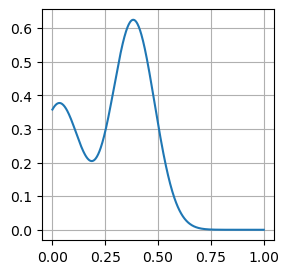

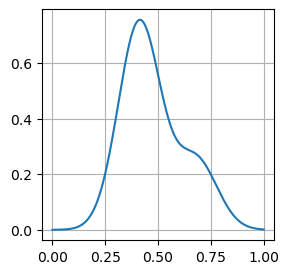

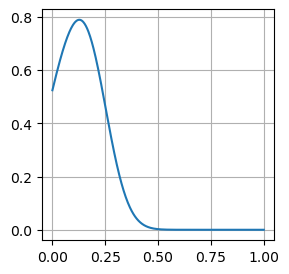

Lengthscale: 0.05
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Max iterations reached
Kappa: 0.5
Max iterations reached
Kappa: 0.6
Kappa: 0.7
Kappa: 0.8
Kappa: 0.9
Kappa: 1.0
Max iterations reached
Kappa: 1.1
Kappa: 1.2
Max iterations reached
Kappa: 1.3
Kappa: 1.4
Kappa: 1.5
Kappa: 1.6
Kappa: 1.7
Kappa: 1.8
Max iterations reached
Kappa: 1.9
Lengthscale: 0.1
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Kappa: 0.6
Kappa: 0.7
Kappa: 0.8
Max iterations reached
Kappa: 0.9
Max iterations reached
Kappa: 1.0
Max iterations reached
Kappa: 1.1
Max iterations reached
Kappa: 1.2
Max iterations reached
Kappa: 1.3
Max iterations reached
Kappa: 1.4
Max iterations reached
Kappa: 1.5
Max iterations reached
Kappa: 1.6
Max iterations reached
Kappa: 1.7
Max iterations reached
Kappa: 1.8
Max iterations reached
Kappa: 1.9
Max iterations reached
Lengthscale: 0.15000000000000002
Kappa: 0.1
Kappa: 0.2
Kappa: 0.3
Kappa: 0.4
Kappa: 0.5
Max iterations reached
Kappa: 0.6
Max iterations reached
Kappa: 0.7


In [36]:
#ucb_kappa = 3
#rbf_lengthscale = 0.2 # lengthscale parameter
test_functions = []
for i in range(3):
    testmu1 = random.random()
    testmu2 = random.random()
    testalpha2 = random.uniform(0.3, 0.9)
    oned = one_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(oned)
    plot_oned_objective(oned) # to see what we're dealing with

results = []
for rbf_lengthscale in np.arange(0.05, 0.25, 0.05):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.1):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        for oned in test_functions:
            iterations_required = test_on_oned(rbf_lengthscale, ucb_kappa, oned, 20)
            fn_result.append(iterations_required)
            #print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            fn+=1
        results.append(fn_result)

output_results_csv(len(test_functions), results)

In [ ]:
#test on 2d functions
twod_input_bounds = [(0, 1), (0,1)]
def test_on_twod(rbf_lengthscale, ucb_acquisition_kappa, test_twod_function, max_iterations):
    
    N = 100
    x0_vals = np.linspace(0, 1, N)
    x1_vals = np.linspace(0, 1, N)
    X0, X1 = np.meshgrid(x0_vals, x1_vals)        # shape (N, N) each
    objective_x = np.column_stack((X0.ravel(), X1.ravel()))  # shape (N*N, 2)
    objective_y = test_twod_function.call_function(objective_x)
    objective_y_max = max(objective_y)


    kernel = RBF(length_scale=rbf_lengthscale)
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)

    X = []
    Y = []
    # First point
    initial_x = bounds_midpoint(twod_input_bounds)  # array([0.5])
    X.append(initial_x)
    Y.append(test_twod_function.call_function(initial_x))
    for i in range(5):
        starting_x = [random.random(), random.random()]
        starting_y = test_twod_function.call_function(starting_x)
        X.append(starting_x)
        Y.append(starting_y)
    
    i=0

    #print("Objective max:", objective_y_max)
    while abs(max(Y) - objective_y_max) > 0.01:
        i+=1
        # print("Max y:", max(Y))
        if i > max_iterations:
            print("Max iterations reached")
            return 0
        #print("Iteration", i, " Max found:", max(Y))
        # print(abs(max(Y) - objective_y_max))
        # fit the model
        model.fit(X, Y)
            
        # optimize the acquisition function
        result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=initial_x, bounds=twod_input_bounds)
        x_new = result.x
        y_new = test_twod_function.call_function(x_new)
        
        # add the new observation to the training set
        X.append(x_new)
        Y.append(y_new)

    return i

test_functions = []
for i in range(3): #5
    testmu1 = [random.random(),random.random()]
    testmu2 = [random.random(),random.random()]
    testalpha2 = random.uniform(0.3, 0.9)
    twod = two_d_test(mu1=testmu1, mu2=testmu2, alpha2=testalpha2)
    test_functions.append(twod)
    plot_twod_objective(twod) # to see what we're dealing with

#test_on_twod(0.15, 0.4, test_functions[0], 20)

results = []
for rbf_lengthscale in np.arange(0.05, 0.5, 0.05):
    print("Lengthscale:", rbf_lengthscale)
    for kappa in np.arange(0.1, 2.00, 0.1):
        ucb_kappa = round(kappa, 2)
        print("Kappa:", ucb_kappa)
        fn = 0
        fn_result = []
        fn_result.append(rbf_lengthscale)
        fn_result.append(ucb_kappa)
        for twod in test_functions:
            iterations_required = test_on_twod(rbf_lengthscale, ucb_kappa, twod, 20)
            fn_result.append(iterations_required)
            print("Lengthscale:", rbf_lengthscale, "Kappa:", ucb_kappa, "Function:", fn, "Needed:", iterations_required)
            fn+=1
        results.append(fn_result)

#print(results)
output_results_csv(len(test_functions), results)


from the output, lengthscale 0.25 kappa 0.3 was about best for 2d

for 1d, lengthscale 0.15 kappa 0.4


In [9]:
#todo: a cutdown version that uses sample data instead of the initial random 5 and calls to the objective function, and suggests next point to explore.
#Use that to do this week's submissions.
#Then, next week, start fitting on functions that are closer to the real ones in terms of local maxima/variance.


def suggest_next(rbf_lengthscale, ucb_acquisition_kappa, function_num):
    kernel = RBF(length_scale=rbf_lengthscale)
    model = GaussianProcessRegressor(kernel = kernel, alpha=noise_assumption)
    X, Y = get_function_data(function_num)
    dimensions = X.shape[1]
    bounds = input_bounds_for_dim(dimensions)
    initial_x = bounds_midpoint(bounds)
    
    model.fit(X, Y)
    
    result = optimize.minimize(lambda x: -acquisition_UCB(x, model, ucb_acquisition_kappa), x0=initial_x, bounds=bounds)
    return result.x


for i in range(1,9):
    print("Function", i)
    formatted = format_for_submission(suggest_next(0.25, 0.3, i))
    print(formatted)

Function 1
[0.12784877 0.19849096]
Function 2
[0.2460767  0.65659691]
Function 3
[0.5 0.5 0.5]
Function 4
[0.51035754 0.52198492 0.38399514 0.44543879]
Function 5
[0.5 0.5 0.5 0.5]
Function 6
[0.66336004 0.         1.         0.33298401 0.        ]
Function 7


c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
c:\Users\mike\anaconda3\Lib\site-packages\sklearn\gaussian_process\kernels.py:445: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


[0.         0.16518481 0.28680961 0.         0.31810943 1.        ]
Function 8
[0.11926467 0.25446646 0.1172752  0.24563019 0.54842642 0.55317239
 0.23011142 0.51606161]
